Loading training data...


Loading NORMAL from ./chest_Xray\train\NORMAL:   0%|          | 0/1342 [00:00<?, ?it/s]

Loading NORMAL from ./chest_Xray\train\NORMAL: 100%|██████████| 1342/1342 [01:02<00:00, 21.63it/s]
Loading PNEUMONIA from ./chest_Xray\train\PNEUMONIA: 100%|██████████| 3876/3876 [00:48<00:00, 79.97it/s] 


Loading validation data...


Loading NORMAL from ./chest_Xray\val\NORMAL: 100%|██████████| 9/9 [00:00<00:00, 41.71it/s]
Loading PNEUMONIA from ./chest_Xray\val\PNEUMONIA: 100%|██████████| 9/9 [00:00<00:00, 124.49it/s]


Loading test data...


Loading NORMAL from ./chest_Xray\test\NORMAL: 100%|██████████| 234/234 [00:05<00:00, 39.58it/s]
Loading PNEUMONIA from ./chest_Xray\test\PNEUMONIA: 100%|██████████| 390/390 [00:03<00:00, 100.82it/s]


Combined training set size: 5232
Training KNN classifier...
Making predictions on test set...

Test set accuracy: 0.7420

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.97      0.32      0.48       234
   PNEUMONIA       0.71      0.99      0.83       390

    accuracy                           0.74       624
   macro avg       0.84      0.66      0.66       624
weighted avg       0.81      0.74      0.70       624



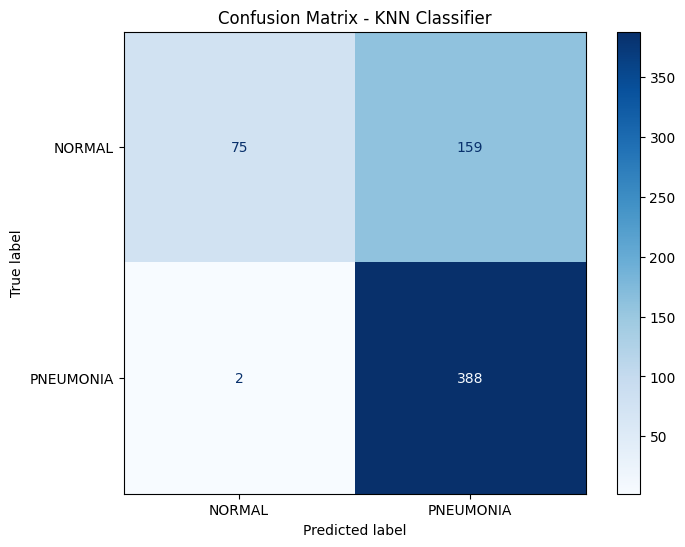


Validation set performance:
Validation accuracy: 0.6250
              precision    recall  f1-score   support

      NORMAL       1.00      0.25      0.40         8
   PNEUMONIA       0.57      1.00      0.73         8

    accuracy                           0.62        16
   macro avg       0.79      0.62      0.56        16
weighted avg       0.79      0.62      0.56        16


Results saved to: ./results_knn_nopca


In [ ]:
import os
import cv2
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot as plt
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from tqdm import tqdm

# CONFIGURATION
IMG_SIZE = 64
CATEGORIES = ["NORMAL", "PNEUMONIA"]
DATASET_DIR = "./chest_Xray"
RESULTS_DIR = "./results_knn_nopca"
os.makedirs(RESULTS_DIR, exist_ok=True)

# DATA LOADING
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in tqdm(os.listdir(folder)):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            images.append(img)
            labels.append(label)
    return images, labels

# Load training data
print("Loading training data...")
X_train_list, y_train_list = [], []
for idx, category in enumerate(CATEGORIES):
    folder_path = os.path.join(DATASET_DIR, "train", category)
    images, labels = load_images_from_folder(folder_path, idx)
    X_train_list.extend(images)
    y_train_list.extend(labels)

# Load validation data
print("Loading validation data...")
X_val_list, y_val_list = [], []
for idx, category in enumerate(CATEGORIES):
    folder_path = os.path.join(DATASET_DIR, "val", category)
    images, labels = load_images_from_folder(folder_path, idx)
    X_val_list.extend(images)
    y_val_list.extend(labels)

# Load test data
print("Loading test data...")
X_test_list, y_test_list = [], []
for idx, category in enumerate(CATEGORIES):
    folder_path = os.path.join(DATASET_DIR, "test", category)
    images, labels = load_images_from_folder(folder_path, idx)
    X_test_list.extend(images)
    y_test_list.extend(labels)

# Sanity check
if len(X_train_list) == 0:
    raise RuntimeError("No training images loaded. Check the dataset paths.")
if len(X_test_list) == 0:
    raise RuntimeError("No test images loaded. Check the dataset paths.")

# PREPROCESSING
X_train = np.array(X_train_list).reshape(len(X_train_list), -1)
y_train = np.array(y_train_list)

X_val = np.array(X_val_list).reshape(len(X_val_list), -1) if X_val_list else None
y_val = np.array(y_val_list) if y_val_list else None

X_test = np.array(X_test_list).reshape(len(X_test_list), -1)
y_test = np.array(y_test_list)

# Combine training and validation sets
if X_val is not None and y_val is not None:
    X_train = np.vstack([X_train, X_val])
    y_train = np.hstack([y_train, y_val])
    print(f"Combined training set size: {len(X_train)}")

# TRAINING
print("Training KNN classifier...")
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# EVALUATION
print("Making predictions on test set...")
y_pred = knn.predict(X_test)

# Test accuracy
test_accuracy = knn.score(X_test, y_test)
print(f"\nTest set accuracy: {test_accuracy:.4f}")

# Classification report
print("\nClassification Report:")
report = classification_report(y_test, y_pred, target_names=CATEGORIES)
print(report)

# Save classification report
with open(os.path.join(RESULTS_DIR, "classification_report.txt"), "w") as f:
    f.write(f"Test set accuracy: {test_accuracy:.4f}\n\n")
    f.write(report)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CATEGORIES)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("Confusion Matrix - KNN Classifier")
plt.savefig(os.path.join(RESULTS_DIR, "confusion_matrix_knn.png"), dpi=300, bbox_inches='tight')
plt.show()


if X_val is not None and len(X_val) > 0:
    print("\nValidation set performance:")
    y_val_pred = knn.predict(X_val)
    val_accuracy = knn.score(X_val, y_val)
    print(f"Validation accuracy: {val_accuracy:.4f}")
    
    val_report = classification_report(y_val, y_val_pred, target_names=CATEGORIES)
    print(val_report)

print(f"\nResults saved to: {RESULTS_DIR}")